# Analyses autour du SARS-CoV-2 (Covid-19)

Les données sont fournies par le [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/) et sont disponible sur [GitHub](https://github.com/CSSEGISandData/COVID-19).

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy import stats

from os.path import exists
import requests

## Récupération des données

On télécharge les données si elles ne sont pas déjà présentent.

**ATTENTION :** comme on peut le voir dans [l'historique des commits du fichier](https://github.com/CSSEGISandData/COVID-19/commits/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) ce dernier est mis à jour plusieurs fois par jour. Je conduis cette analyse avec le fichier du commit numéro `1b7e885187acaf46b1099b103d38da0b21e570ee`. Le fichier à ce moment est visible via ce [lien](https://github.com/CSSEGISandData/COVID-19/blob/1b7e885187acaf46b1099b103d38da0b21e570ee/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv).

In [2]:
def get_file(url, path):
    # Download the file if it does not exists
    if not exists(path):
        print('Download file')
        res = requests.get(url, allow_redirects=True)
        open(path, 'wb').write(res.content)
    if path.endswith('.csv'):
        return pd.read_csv(path)
    elif path.endswith('.xlsx'):
        return pd.read_excel(path)

In [3]:
data = get_file("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                'time_series_covid19_confirmed_global.csv')
data.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20   ...     11/28/22  11/29/22  11/30/22  \
0        0        0        0        0   ...       205802    205830    205907   
1        0        0        0        0   ...       333330    333338    333343   
2        0        0        0        0   ...       271079    271082    271090   
3        0        0        0        0   ...        46824     46824     47219   
4        0        0        0        0   ...       104491    104491    104676   

   12/1/22  12/2/22  12/3/22  12/4/22  12/5/22  12/6/22  12/7/22  
0   206073   206133   206145   206206   206273   206331   206414  
1   333360   333381   333391   333408   333413   333455   333472  
2   271096   271100   271102   271107   271113   271122   271128  
3    47219    47219    47219    47219    47219    47219    47446  
4   104676   104676   104676   104676   104750   104750   104808  

[5 rows x 1055 columns]

Ce fichier contient le nombre de cas confirmés par pays. Chaque ligne correpond à un état d'un pays. La 1ère colonne correspond à l'état, la 2ème au pays, la 3ème à la latitude, la 4ème à la longitude et chaque colonne après correspond à une journée et contient le nombre de cas cumulés confirmés depuis le début de l'épidémie.

**ATTENTION :** en regardant la période diponible j'ai remarqué que les dates sont au format américain : mois/jour/année.  
*Tous le monde sait que seuls les formats jour/mois/année et année/mois/jour ont du sens.*   
Je prépare donc une fonction pour parser les dates.

In [4]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%m/%d/%y')

Regardons un peu se que l'on trouve dans ce fichier...

In [5]:
def data_overview(data):
    print("Nombre d'états :", data.shape[0], sep='\t')
    print('Nombre de pays :', len(data['Country/Region'].unique()), sep='\t')
    print("Nombre de jours :", data.shape[1] - 4, sep='\t')
    print("1er jour dispo :", parse_date(data.columns[4]).date(), sep='\t')
    print("dernier jour dispo :", parse_date(data.columns[-1]).date(), sep='\t')
    
data_overview(data)

Nombre d'états :	289
Nombre de pays :	201
Nombre de jours :	1051
1er jour dispo :	2020-01-22
dernier jour dispo :	2022-12-07


## Analyse par pays

La consigne est de montrer l'évolution du nombre de cas confirmés pour ces pays : la Belgique (Belgium), la Chine - toutes les provinces sauf Hong-Kong (China), Hong Kong (China, Hong-Kong), la France métropolitaine (France), l’Allemagne (Germany), l’Iran (Iran), l’Italie (Italy), le Japon (Japan), la Corée du Sud (Korea, South), la Hollande sans les colonies (Netherlands), le Portugal (Portugal), l’Espagne (Spain), le Royaume-Unis sans les colonies (United Kingdom), les États-Unis (US).

In [30]:
countries = ['Belgium', 'China', 'China, Hong-Kong', 'France', 'Germany', 'Iran', 'Italy', 'Japan', 'Korea, South',
             'Netherlands', 'Portugal', 'Spain', 'United Kingdom', 'US']

On vérifie conbien de ligne ont trouve pour chaque pays.

In [31]:
for country in countries:
    print(country, len(data[data['Country/Region'] == country]))

Belgium 1
China 34
China, Hong-Kong 0
France 12
Germany 1
Iran 1
Italy 1
Japan 1
Korea, South 1
Netherlands 5
Portugal 1
Spain 1
United Kingdom 15
US 1


Ceux qui ne contiennent qu'une seule ligne sont triviaux, les autres nécessite d'être regardé en détails.

In [8]:
data[data['Country/Region'] == 'China']

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
59           Anhui          China  31.8257  117.2264        1        9   
60         Beijing          China  40.1824  116.4142       14       22   
61       Chongqing          China  30.0572  107.8740        6        9   
62          Fujian          China  26.0789  117.9874        1        5   
63           Gansu          China  35.7518  104.2861        0        2   
64       Guangdong          China  23.3417  113.4244       26       32   
65         Guangxi          China  23.8298  108.7881        2        5   
66         Guizhou          China  26.8154  106.8748        1        3   
67          Hainan          China  19.1959  109.7453        4        5   
68           Hebei          China  39.5490  116.1306        1        1   
69    Heilongjiang          China  47.8620  127.7615        0        2   
70           Henan          China  37.8957  114.9042        5        5   
71       Hong Kong          China  22.3000  114.2000        0        2   
72           Hubei          China  30.9756  112.2707      444      444   
73           Hunan          China  27.6104  111.7088        4        9   
74  Inner Mongolia          China  44.0935  113.9448        0        0   
75         Jiangsu          China  32.9711  119.4550        1        5   
76         Jiangxi          China  27.6140  115.7221        2        7   
77           Jilin          China  43.6661  126.1923        0        1   
78        Liaoning          China  41.2956  122.6085        2        3   
79           Macau          China  22.1667  113.5500        1        2   
80         Ningxia          China  37.2692  106.1655        1        1   
81         Qinghai          China  35.7452   95.9956        0        0   
82         Shaanxi          China  35.1917  108.8701        0        3   
83        Shandong          China  36.3427  118.1498        2        6   
84        Shanghai          China  31.2020  121.4491        9       16   
85          Shanxi          China  37.5777  112.2922        1        1   
86         Sichuan          China  30.6171  102.7103        5        8   
87         Tianjin          China  39.3054  117.3230        4        4   
88           Tibet          China  31.6927   88.0924        0        0   
89         Unknown          China      NaN       NaN        0        0   
90        Xinjiang          China  41.1129   85.2401        0        2   
91          Yunnan          China  24.9740  101.4870        1        2   
92        Zhejiang          China  29.1832  120.0934       10       27   

    1/24/20  1/25/20  1/26/20  1/27/20   ...     11/28/22  11/29/22  11/30/22  \
59       15       39       60       70   ...         1596      1614      1614   
60       36       41       68       80   ...        11520     11520     13840   
61       27       57       75      110   ...         5661      5829      5829   
62       10       18       35       59   ...         6019      6085      6085   
63        2        4        7       14   ...         1547      1551      1551   
64       53       78      111      151   ...        34114     35643     37254   
65       23       23       36       46   ...         2386      2395      2395   
66        3        4        5        7   ...         1277      1297      1297   
67        8       19       22       33   ...         9077      9092      9092   
68        2        8       13       18   ...         2182      2767      2767   
69        4        9       15       21   ...         4332      4434      4434   
70        9       32       83      128   ...         7144      7144      7277   
71        2        5        8        8   ...      2101888   2109435   2118245   
72      549      761     1058     1423   ...        68561     68609     68609   
73       24       43       69      100   ...         2040      2129      2129   
74        1        7        7       11   ...         7480      7587      7664   
75        9       18       33       

Pour la **Chine** on veut toutes les ligne sauf celle ayant "Hong Kong" comme région.

Pour **Hong Kong** on veut la ligne ayant "China" comme pays et "Hong Kong" comme région.

In [9]:
data[data['Country/Region'] == 'France']

Province/State Country/Region        Lat        Long  1/22/20  \
120              French Guiana         France   3.933900  -53.125800        0   
121           French Polynesia         France -17.679700  149.406800        0   
122                 Guadeloupe         France  16.265000  -61.551000        0   
123                 Martinique         France  14.641500  -61.024200        0   
124                    Mayotte         France -12.827500   45.166244        0   
125              New Caledonia         France -20.904305  165.618042        0   
126                    Reunion         France -21.115100   55.536400        0   
127           Saint Barthelemy         France  17.900000  -62.833300        0   
128  Saint Pierre and Miquelon         France  46.885200  -56.315900        0   
129                  St Martin         France  18.070800  -63.050100        0   
130          Wallis and Futuna         France -14.293800 -178.116500        0   
131                        NaN         France  46.227600    2.213700        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20    ...     11/28/22  \
120        0        0        0        0        0    ...        95451   
121        0        0        0        0        0    ...        76899   
122        0        0        0        0        0    ...       197105   
123        0        0        0        0        0    ...       223877   
124        0        0        0        0        0    ...        41176   
125        0        0        0        0        0    ...        75258   
126        0        0        0        0        0    ...       480323   
127        0        0        0        0        0    ...         5336   
128        0        0        0        0        0    ...         3248   
129        0        0        0        0        0    ...        12034   
130        0        0        0        0        0    ...         3415   
131        0        2        3        3        3    ...     36671077   

     11/29/22  11/30/22   12/1/22   12/2/22   12/3/22   12/4/22   12/5/22  \
120     95451     95451     95451     96389     96389     96389     96389   
121     76899     76985     77137     77137     77137     77137     77275   
122    197918    197918    197918    197918    197918    197918    197918   
123    224468    224468    224468    224468    224468    224468    224468   
124     41176     41176     41206     41206     41206     41206     41679   
125     76051     76187     76187     76187     76187     76187     76187   
126    480323    480323    481540    481540    481540    481540    481540   
127      5348      5348      5348      5348      5348      5348      5348   
128      3250      3250      3282      3282      3282      3282      3282   
129     12058     12058     12058     12058     12058     12058     12058   
130      3415      3415      3415      3415      3415      3415      3415   
131  36762891  36829869  36897875  36955945  36955945  36955945  37058977   

      12/6/22   12/7/22  
120     96389     96389  
121     77275     77416  
122    197918    197918  
123    224468    224468  
124     41679     41679  
125     77127     77263  
126    481540    481540  
127      5348      5348  
128      3282      3282  
129     12058     12058  
130      3415      3415  
131  37164493  37240245  

[12 rows x 1055 columns]

Pour la **France** on veut uniquement la ligne sans région ("NaN").

Idem pour la **Hollande** et le **Royaume-Unis**.

On peut désormais faire la courbe de l'évolution par pays...

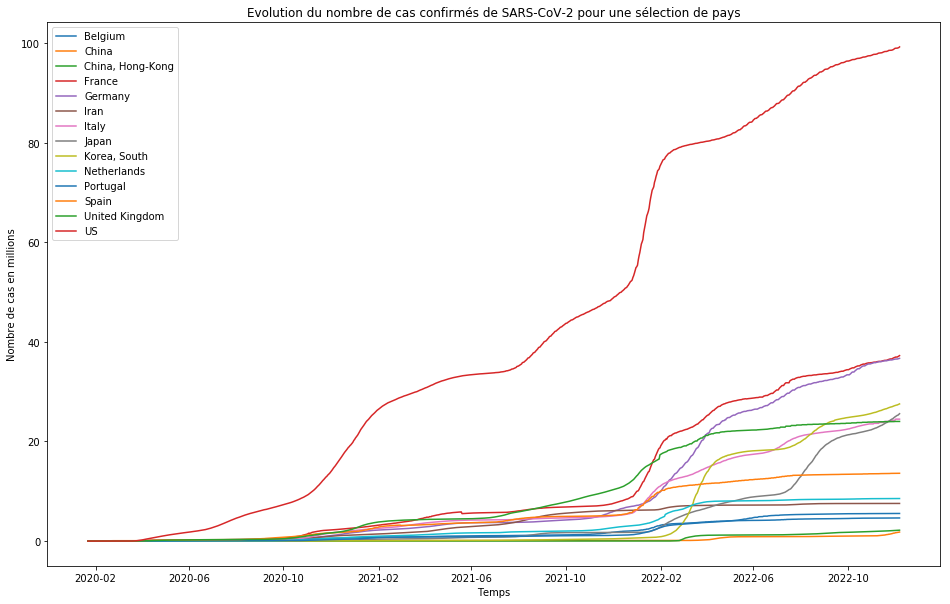

In [10]:
dates = [parse_date(d) for d in data.columns[4:]]

def plot(data=data, yscale='linear'):
    plt.figure(figsize=(16,10))
    plt.title('Evolution du nombre de cas confirmés de SARS-CoV-2 pour une sélection de pays')
    plt.xlabel('Temps')
    plt.ylabel('Nombre de cas en millions')
    plt.yscale(yscale)
    
    curves = []

    for country in countries:
        # Get the data for the country
        if country == 'China':
            country_data = data[(data['Country/Region'] == 'China') & (data['Province/State'] != 'Hong Kong')]
            assert len(country_data) is 33
        elif country == 'China, Hong-Kong':
            country_data = data[(data['Country/Region'] == 'China') & (data['Province/State'] == 'Hong Kong')]
            assert len(country_data) is 1
        elif country in ['France', 'Netherlands', 'United Kingdom']:
            country_data = data[(data['Country/Region'] == country) & data['Province/State'].isnull()]
            assert len(country_data) is 1
        else:
            country_data = data[data['Country/Region'] == country]
            assert len(country_data) is 1, 'There is more or less than 1 line for country ' + country

        # Make x
        x = [country_data[col].sum() / 1000000 for col in data.columns[4:]]

        # Plot
        curve, = plt.plot(dates, x)
        curves.append(curve)

    plt.legend(curves, countries)
    plt.show()
    
plot()

On remarque une grosse augmentation du nombre de début 2022 dans la majorité des pays. Cela pourrait correspondre au variant Omicron qui est apparu fin novembre 2021 et est plus transmissible (source : [WHO](https://www.who.int/activities/tracking-SARS-CoV-2-variants)).

Maintenant le même graphe avec une échelle logarithmique.

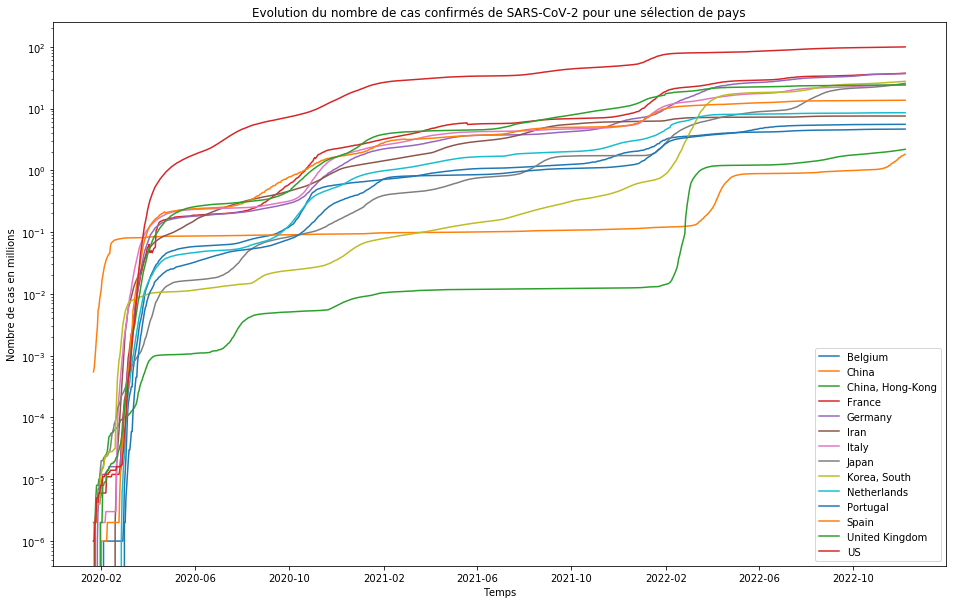

In [11]:
plot(yscale='log')

## Analyse du nombre de morts

In [12]:
death_data = get_file("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv",
                'time_series_covid19_deaths_global.csv')
death_data.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20   ...     11/28/22  11/29/22  11/30/22  \
0        0        0        0        0   ...         7833      7833      7833   
1        0        0        0        0   ...         3594      3594      3594   
2        0        0        0        0   ...         6881      6881      6881   
3        0        0        0        0   ...          156       156       157   
4        0        0        0        0   ...         1923      1923      1924   

   12/1/22  12/2/22  12/3/22  12/4/22  12/5/22  12/6/22  12/7/22  
0     7834     7834     7834     7834     7835     7835     7837  
1     3594     3594     3594     3594     3594     3594     3594  
2     6881     6881     6881     6881     6881     6881     6881  
3      157      157      157      157      157      157      158  
4     1924     1924     1924     1924     1925     1925     1925  

[5 rows x 1055 columns]

In [13]:
data_overview(death_data)

Nombre d'états :	289
Nombre de pays :	201
Nombre de jours :	1051
1er jour dispo :	2020-01-22
dernier jour dispo :	2022-12-07


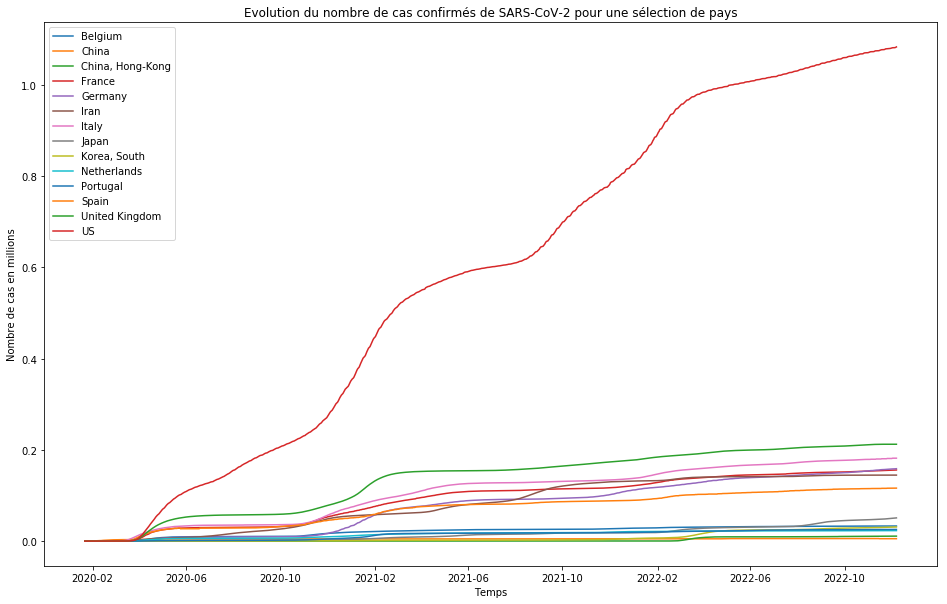

In [14]:
plot(data=death_data)

Pour les mort ont n'a pas la même augmentation début 2022 se qui laisse supposé qu'omicron tue moins. Cela peut venir d'une dangerosité plus faible ou d'une amélioration de la prose en charge des malades depuis le début de l'épidémie.

En revanche on note une rapide augmentation du nombre de mort début 2021, trois variants sont effectivement apparu fin 2020 : Alpha en septembre, Delta en octobre et Gamma en novembre.

Les auteurs du MOOC suggèrent d'étudier la présence d'une corrélation entre le nombre de lit d'hopital et le nombre de mort. Le [dernier rapport de L'OCDE](https://www.oecd-ilibrary.org/sites/e5a80353-en/index.html?itemId=/content/component/e5a80353-en#:~:text=Across%20OECD%20countries%2C%20there%20were,\)%2C%20rates%20were%20much%20higher.) est celui de l'année 2021 et il inclut le nombre de lit uniquement jusqu'à 2019 or les chiffres que nous possédons sur l'épidémie commencent en 2020. Il y a donc un décalage. Nous faisons néanmoins l'analyse.

Le fichier fourni par l'OCDE est disponible à ce [lien](https://stat.link/files/ae3016b9-en/upe1dn.xlsx). Il contient une courbe se qui empêche de l'ouvrir avec Pandas, j'ai donc fais un export des données depuis libreoffice dans le fichier "bed.csv". Dommage que l'OCDE ne fournisse pas ses données dan sun format libre et ne fasse pas ses graphiques dans une document computationnel.

In [15]:
bed_data = pd.read_csv('bed.csv')
bed_data

Country  2009  2019
0             Japan  13.6  12.8
1             Korea   8.2  12.4
2            Russia   9.7   8.0
3           Germany   8.2   7.9
4           Austria   7.7   7.2
5           Hungary   7.1   6.9
6    Czech Republic   7.1   6.6
7         Lithuania   7.2   6.4
8            Poland   6.7   6.2
9            France   6.7   5.8
10  Slovak Republic   6.5   5.8
11          Belgium   6.2   5.6
12           Latvia   6.7   5.4
13            China   2.3   4.8
14      Switzerland   5.1   4.6
15          Estonia   5.4   4.5
16         Slovenia   4.6   4.4
17           OECD38   4.8   4.4
18       Luxembourg   5.5   4.3
19           Greece   4.5   4.2
20        Australia   3.8   3.8
21         Portugal   3.4   3.5
22           Norway   4.5   3.5
23          Finland   6.3   3.4
24            Italy   3.7   3.2
25      Netherlands   4.2   3.1
26           Israel   3.2   3.0
27            Spain   3.2   3.0
28          Ireland   2.8   2.9
29           Turkey   2.6   2.9
30    United States   3.1   2.8
31          Iceland   3.7   2.8
32          Denmark   3.1   2.6
33      New Zealand   2.4   2.5
34           Canada   2.8   2.5
35   United Kingdom   2.9   2.5
36           Sweden   2.8   2.1
37            Chile   2.3   2.0
38         Colombia   1.5   1.7
39       Costa Rica   1.2   1.1
40        Indonesia   0.6   1.0
41           Mexico   1.0   1.0
42            India   0.4   0.5

Les nombres sont pour 1000 habitants.

In [19]:
for country in countries:
    if country not in list(bed_data['Country']):
        print(country, "est manquant des données de l'OCDE")

China, Hong-Kong est manquant des données de l'OCDE
Iran est manquant des données de l'OCDE
Korea, South est manquant des données de l'OCDE
US est manquant des données de l'OCDE


Hong Kong est vraisemblablement inclu dans la Chine.

L'Iran est complètement absent.

On trouve Korea dans les données de l'OCDE mais aucune idée de si cela inclu la Corée du Nord ou juste le sud.

US est nommé "United States" dans les fichiers de l'OCDE.

On peut récupérer la population mondiale sur le site [data.worldbank.org](https://data.worldbank.org/indicator/SP.POP.TOTL) on récupère les csv dans un zip. Celui qui nous intérresse est "API_SP.POP.TOTL_DS2_en_csv_v2_4701113.csv", je l'ai upload à la main dans le repo sous le nom "population.csv". Il contient 4 lignes de commentaires en haut, on les skip lors du chargement des données.

In [57]:
population = pd.read_csv('population.csv', skiprows=4)
population.head()

Country Name Country Code     Indicator Name Indicator Code  \
0                        Aruba          ABW  Population, total    SP.POP.TOTL   
1  Africa Eastern and Southern          AFE  Population, total    SP.POP.TOTL   
2                  Afghanistan          AFG  Population, total    SP.POP.TOTL   
3   Africa Western and Central          AFW  Population, total    SP.POP.TOTL   
4                       Angola          AGO  Population, total    SP.POP.TOTL   

          1960         1961         1962         1963         1964  \
0      54208.0      55434.0      56234.0      56699.0      57029.0   
1  130836765.0  134159786.0  137614644.0  141202036.0  144920186.0   
2    8996967.0    9169406.0    9351442.0    9543200.0    9744772.0   
3   96396419.0   98407221.0  100506960.0  102691339.0  104953470.0   
4    5454938.0    5531451.0    5608499.0    5679409.0    5734995.0   

          1965     ...              2013         2014         2015  \
0      57357.0     ...          103165.0     103776.0     104339.0   
1  148769974.0     ...       562601578.0  578075373.0  593871847.0   
2    9956318.0     ...        32269592.0   33370804.0   34413603.0   
3  107289875.0     ...       380437896.0  390882979.0  401586651.0   
4    5770573.0     ...        26015786.0   26941773.0   27884380.0   

          2016         2017         2018         2019         2020  \
0     104865.0     105361.0     105846.0     106310.0     106766.0   
1  609978946.0  626392880.0  643090131.0  660046272.0  677243299.0   
2   35383028.0   36296111.0   37171922.0   38041757.0   38928341.0   
3  412551299.0  423769930.0  435229381.0  446911598.0  458803476.0   
4   28842482.0   29816769.0   30809787.0   31825299.0   32866268.0   

          2021  Unnamed: 66  
0     107195.0          NaN  
1  694665117.0          NaN  
2   39835428.0          NaN  
3  470898870.0          NaN  
4   33933611.0          NaN  

[5 rows x 67 columns]

In [23]:
for country in countries:
    if country not in list(population['Country Name']):
        print(country, "est manquant des données de worldbank.org")

China, Hong-Kong est manquant des données de worldbank.org
Iran est manquant des données de worldbank.org
Korea, South est manquant des données de worldbank.org
US est manquant des données de worldbank.org


Même problème qu'avec les données de l'OCDE à part que l'Iran est présent sous le nom "Iran, Islamic Rep.".

La solution adopté est d'inclure Hong Kong dans la Chine, omettre l'Iran et la Corée et pour les états-unis on adapte juste le nom à la source des données.

Par ailleurs les DOM/TOM sont inclu dans la population de la France.

In [47]:
for country in ['Netherlands', 'United Kingdom']:
    print('--', country)
    for state in death_data[death_data['Country/Region'] == country]['Province/State']:
        if type(state) is str and len(population[population['Country Name'].str.contains(state)]) > 0:
            print('La province', state, 'est considéré comme un pays dans le fichier de données')

-- Netherlands
La province Aruba est considéré comme un pays dans le fichier de données
La province Curacao est considéré comme un pays dans le fichier de données
La province Sint Maarten est considéré comme un pays dans le fichier de données
-- United Kingdom
La province Bermuda est considéré comme un pays dans le fichier de données
La province British Virgin Islands est considéré comme un pays dans le fichier de données
La province Cayman Islands est considéré comme un pays dans le fichier de données
La province Channel Islands est considéré comme un pays dans le fichier de données
La province Gibraltar est considéré comme un pays dans le fichier de données
La province Isle of Man est considéré comme un pays dans le fichier de données
La province Turks and Caicos Islands est considéré comme un pays dans le fichier de données


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


Les colonnies de la Hollande et du Royaume Uni sont considérées comme des pays.

In [90]:
def plot_death_bed(countries):
    data = death_data
    death_bed_data = []

    plt.figure(figsize=(16,10))
    plt.title("Nombre de mort en fonction du nombre de lit d'hopital")
    plt.xlabel('Nombre de lit (pour 1000 habitants)')
    plt.ylabel('Nombre de mort (pour 1000 habitants)')
    
    for country in countries:
        # Get the data for the country
        if country == 'United States':
            country_data = data[(data['Country/Region'] == 'US') & data['Province/State'].isnull()]
        elif country in ['Netherlands', 'United Kingdom']:
            country_data = data[(data['Country/Region'] == country) & data['Province/State'].isnull()]
        else:
            country_data = data[data['Country/Region'] == country]
            
        if len(country_data):
            if country == 'US':
                country = 'United States'
                
            if country == 'Russia':
                pop = population[population['Country Name'] == 'Russian Federation']
            else:
                pop = population[population['Country Name'] == country]
            
            if len(pop) == 1:
                pop = pop.iloc[0]['2019']
                beds_1000_pop = bed_data[bed_data['Country'] == country].iloc[0]['2019']

                death_1000_pop = country_data[data.columns[-1]].sum() / (pop / 1000)

                # Plot
                curve, = plt.plot(beds_1000_pop, death_1000_pop, 'o')
                plt.text(beds_1000_pop, death_1000_pop, country)
                
                death_bed_data.append([country, beds_1000_pop, death_1000_pop])
            elif len(pop) > 1:
                print('Multiple population match for', country)
    plt.show()
    
    return pd.DataFrame(death_bed_data, columns=['Country', 'Beds', 'Deaths'])

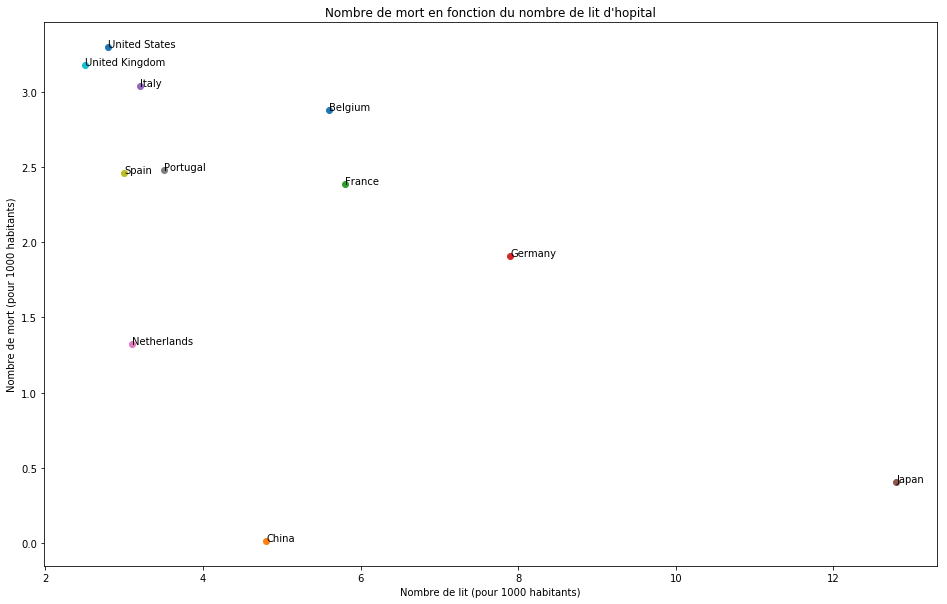

In [89]:
death_bed_data = plot_death_bed([country for country in countries if country not in ['China, Hong-Kong', 'Iran', 'Korea, South']])

In [91]:
stats.spearmanr(death_bed_data['Beds'], death_bed_data['Deaths'])

SpearmanrResult(correlation=-0.6272727272727273, pvalue=0.03884525362035334)

Pour les pays demandés par les auteurs du MOOC il y a une forte corrélation négative entre le nombre de lit et le nombre de mort. i.e. plus il y a de lits d'hopital moins il y a de morts.

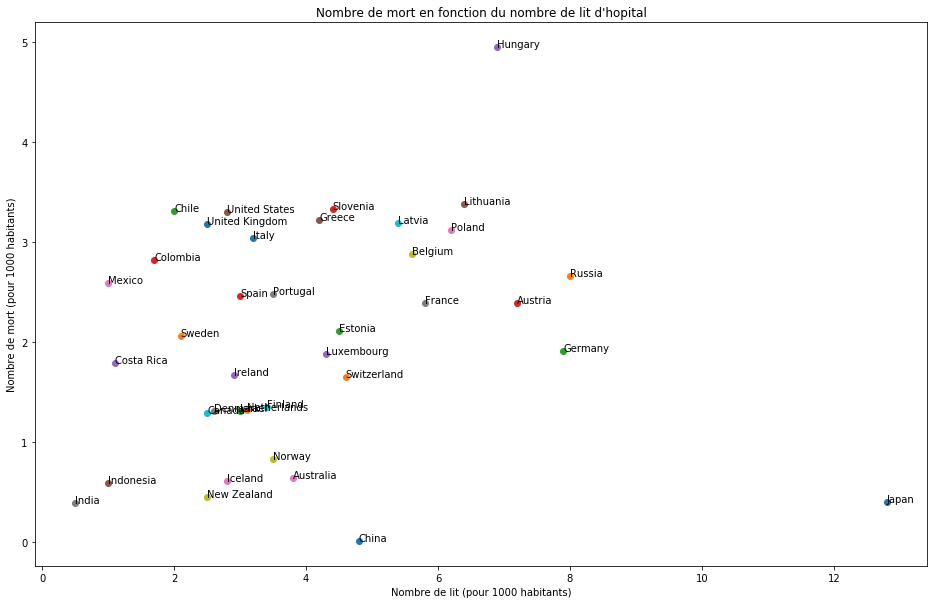

In [92]:
death_bed_data = plot_death_bed(bed_data['Country'])

In [93]:
stats.spearmanr(death_bed_data['Beds'], death_bed_data['Deaths'])

SpearmanrResult(correlation=0.2352490646984116, pvalue=0.15509226958149783)

En revanche si on regarde l'ensemble des pays on trouve une légère corrélation positive. i.e. plus il y a de lits plus il y a de morts. Néanmoins la pvalue est supérieur à 0.05, elle est donc trop élevée pour rejeter la null hypothesis selon laquelle les deux valeurs ne seraient pas corrélées.